In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import wave 
import time 
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad

# Fungsi untuk membaca file audio WAV
def read_audio(file_path):
    with wave.open(file_path, 'rb') as wav_file:  # Buka file dalam mode baca
        params = wav_file.getparams()  # Simpan parameter audio (sample rate, channels, dll)
        frames = wav_file.readframes(params.nframes)  # Ambil isi suara dalam bentuk byte
    return frames, params 

# Fungsi untuk menyimpan hasil enkripsi ke file WAV baru
def write_audio(file_path, audio_data, params):
    with wave.open(file_path, 'wb') as wav_file:  # Buka file dalam mode tulis
        wav_file.setparams(params)  # Pakai parameter yang sama dengan file aslinya
        wav_file.writeframes(audio_data)  # Tulis data audio ke file

# Fungsi untuk memastikan panjang key sudah sesuai dengan standar AES (16/24/32 karakter)
def validate_key(key_str):
    key_length = len(key_str)
    if key_length not in (16, 24, 32):  # Kalau panjang key tidak sesuai, munculkan error
        raise ValueError(f"Key harus 16, 24, atau 32 karakter (sekarang {key_length}).")
    return key_str.encode()  # Ubah key ke bentuk byte

# Fungsi untuk memastikan panjang IV (khusus untuk CBC) adalah 16 karakter
def validate_iv(iv_str):
    iv_length = len(iv_str)
    if iv_length != 16:
        raise ValueError(f"IV harus 16 karakter (sekarang {iv_length}).")
    return iv_str.encode()  # Ubah IV ke bentuk byte

# Fungsi enkripsi dengan mode AES-ECB
def encrypt_audio_aes_ecb(audio_data, key):
    cipher = AES.new(key, AES.MODE_ECB)  # Buat objek enkripsi AES dengan mode ECB
    padded_data = pad(audio_data, AES.block_size)  # Tambahkan padding ke data audio
    return cipher.encrypt(padded_data)

# Fungsi enkripsi dengan mode AES-CBC
def encrypt_audio_aes_cbc(audio_data, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, iv)  # Buat objek enkripsi AES dengan mode CBC dan IV
    padded_data = pad(audio_data, AES.block_size)  # Tambahkan padding
    return cipher.encrypt(padded_data)  # Kembalikan hasil enkripsi

# Kelas utama GUI
class AudioEncryptApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Enkripsi Audio AES")  # Judul jendela aplikasi
        self.file_path = ""  # Untuk menyimpan path file yang dipilih

        # Buat label dan tombol untuk memilih file
        tk.Label(root, text="Pilih file audio WAV:").pack(pady=5)
        tk.Button(root, text="Pilih File", command=self.select_file).pack()

        # Entry untuk input key dari user
        tk.Label(root, text="Masukkan key (16/24/32 karakter):").pack(pady=5)
        self.key_entry = tk.Entry(root, width=40)
        self.key_entry.pack()

        # Entry untuk input IV (hanya untuk CBC)
        tk.Label(root, text="Masukkan IV (16 karakter, hanya untuk CBC):").pack(pady=5)
        self.iv_entry = tk.Entry(root, width=40)
        self.iv_entry.pack()

        # Tombol enkripsi ECB
        self.encrypt_ecb_btn = tk.Button(root, text="Enkripsi AES-ECB", command=self.encrypt_ecb, state=tk.DISABLED)
        self.encrypt_ecb_btn.pack(pady=5)

        # Tombol enkripsi CBC
        self.encrypt_cbc_btn = tk.Button(root, text="Enkripsi AES-CBC", command=self.encrypt_cbc, state=tk.DISABLED)
        self.encrypt_cbc_btn.pack(pady=5)

    # Fungsi untuk memilih file audio WAV
    def select_file(self):
        self.file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav")])
        if self.file_path:
            self.encrypt_ecb_btn.config(state=tk.NORMAL)
            self.encrypt_cbc_btn.config(state=tk.NORMAL) 

    # Fungsi untuk mengambil key yang dimasukkan user dan validasi
    def get_valid_key(self):
        key_input = self.key_entry.get()
        try:
            return validate_key(key_input)
        except ValueError as e:
            messagebox.showerror("Key Error", str(e))
            return None

    # Fungsi untuk mengambil IV dari input user dan validasi
    def get_valid_iv(self):
        iv_input = self.iv_entry.get()
        try:
            return validate_iv(iv_input)
        except ValueError as e:
            messagebox.showerror("IV Error", str(e))
            return None

    # Fungsi untuk enkripsi dengan AES-ECB
    def encrypt_ecb(self):
        key = self.get_valid_key()
        if not key: return  # Kalau key tidak valid, hentikan proses
        try:
            audio_data, params = read_audio(self.file_path)
            start_time = time.time()
            encrypted = encrypt_audio_aes_ecb(audio_data, key)  # Enkripsi data
            end_time = time.time()
            duration = end_time - start_time  # Hitung waktu eksekusi

            # Dialog simpan file hasil
            output = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV files", "*.wav")])
            if output:
                write_audio(output, encrypted, params)
                print("\n=== WAKTU EKSEKUSI AES-ECB ===")
                print(f"Detik      : {duration:.6f} s")
                print(f"Milidetik  : {duration * 1000:.2f} ms")
                print(f"Mikrodetik : {duration * 1_000_000:.0f} µs")
                print(f"Nanodetik  : {duration * 1_000_000_000:.0f} ns")
                messagebox.showinfo("Sukses", f"Enkripsi AES-ECB selesai!\nWaktu eksekusi: {duration:.4f} detik")
        except Exception as e:
            messagebox.showerror("Error", str(e))

    # Fungsi untuk enkripsi dengan AES-CBC
    def encrypt_cbc(self):
        key = self.get_valid_key()
        iv = self.get_valid_iv()
        if not key or not iv: return  # Kalau key atau IV salah, hentikan
        try:
            audio_data, params = read_audio(self.file_path)  # Baca audio
            start_time = time.time()  # Waktu mulai
            encrypted = encrypt_audio_aes_cbc(audio_data, key, iv)  # Enkripsi dengan CBC
            end_time = time.time()
            duration = end_time - start_time  # Waktu selesai - mulai

            # Dialog simpan hasil
            output = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV files", "*.wav")])
            if output:
                write_audio(output, iv + encrypted, params)  # Simpan IV + hasil enkripsi
                print("\n=== WAKTU EKSEKUSI AES-CBC ===")
                print(f"Detik      : {duration:.6f} s")
                print(f"Milidetik  : {duration * 1000:.2f} ms")
                print(f"Mikrodetik : {duration * 1_000_000:.0f} µs")
                print(f"Nanodetik  : {duration * 1_000_000_000:.0f} ns")
                messagebox.showinfo("Sukses", f"Enkripsi AES-CBC selesai!\nWaktu eksekusi: {duration:.4f} detik")
        except Exception as e:
            messagebox.showerror("Error", str(e))

# Jalankan program GUI
if __name__ == "__main__":
    root = tk.Tk()
    app = AudioEncryptApp(root)
    root.mainloop()

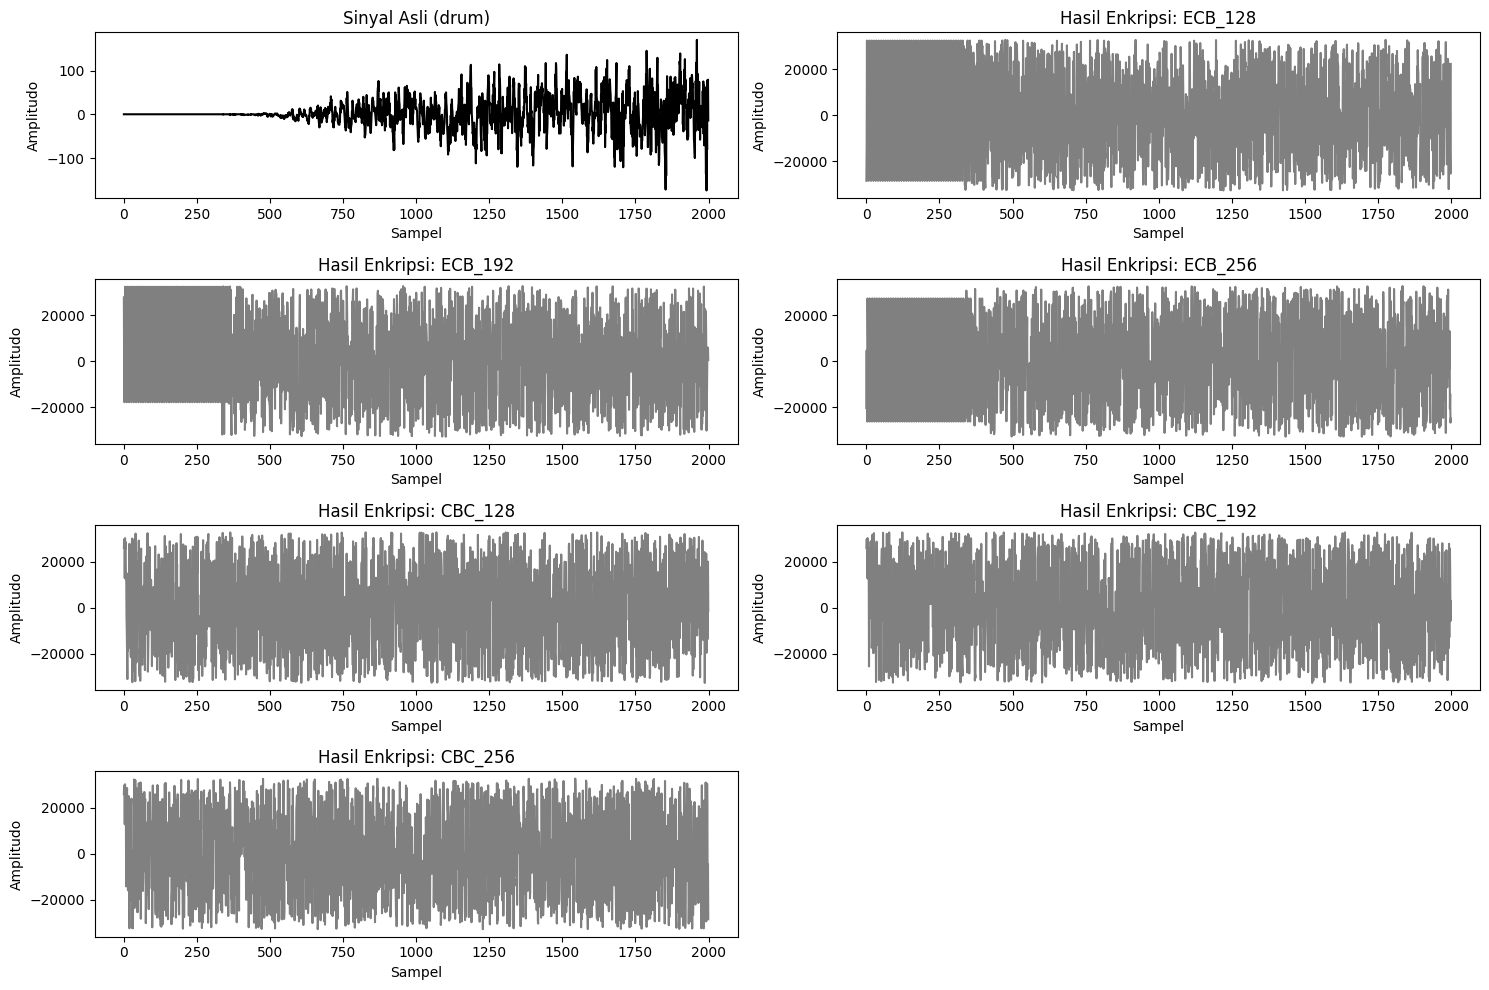

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import wave

# Fungsi membaca file WAV jadi array numpy
def read_audio_as_array(file_path):
    with wave.open(file_path, 'rb') as wav_file:
        frames = wav_file.readframes(wav_file.getnframes())
        audio_array = np.frombuffer(frames, dtype=np.int16)
    return audio_array

# === PILIH AUDIO YANG INGIN DIUJI ===
jenis_audio = "drum"  # Ganti dengan "burung" atau "manusia" jika perlu

# === Load semua file berdasarkan jenis audio ===
audio_files = {
    "original": f"suara{jenis_audio}.wav",
    "ecb_128": f"{jenis_audio}128ecb.wav",
    "cbc_128": f"{jenis_audio}128cbc.wav",
    "ecb_192": f"{jenis_audio}192ecb.wav",
    "cbc_192": f"{jenis_audio}192cbc.wav",
    "ecb_256": f"{jenis_audio}256ecb.wav",
    "cbc_256": f"{jenis_audio}256cbc.wav",
}

# Baca sinyal asli
original_signal = read_audio_as_array(audio_files["original"])

# Simpan hasil sinyal ke dictionary
results = {}
for mode in ["ecb", "cbc"]:
    for bits in [128, 192, 256]:
        key = f"{mode}_{bits}"
        enc_signal = read_audio_as_array(audio_files[key])
        min_len = min(len(original_signal), len(enc_signal))
        results[key] = enc_signal[:min_len]

# === Visualisasi gelombang sinyal audio ===
plt.figure(figsize=(15, 10))
plt.subplot(4, 2, 1)
plt.plot(original_signal[:2000], color='black')
plt.title(f"Sinyal Asli ({jenis_audio})")
plt.xlabel("Sampel")
plt.ylabel("Amplitudo")

for i, (key, signal) in enumerate(results.items()):
    plt.subplot(4, 2, i + 2)
    plt.plot(signal[:2000], label=key.upper(), color='gray')
    plt.title(f"Hasil Enkripsi: {key.upper()}")
    plt.xlabel("Sampel")
    plt.ylabel("Amplitudo")

plt.tight_layout()
plt.show()


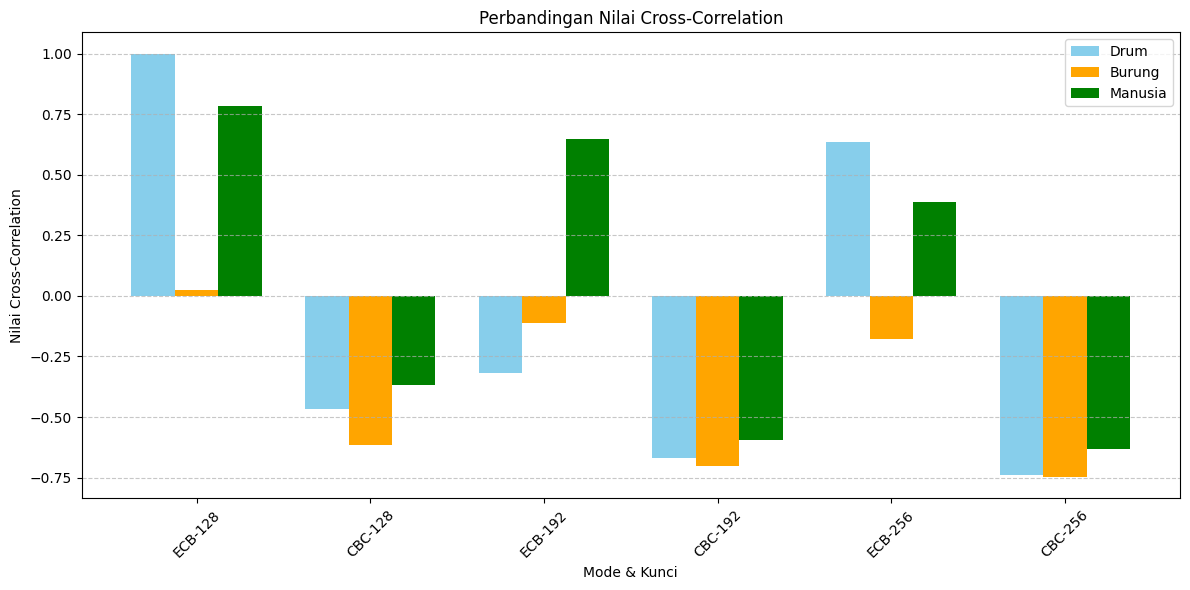

In [ ]:
import matplotlib.pyplot as plt

# Data nilai maksimum cross-correlation
cross_corr = {
    "drum": {
        "ECB-128": 31702,
        "CBC-128": 8423,
        "ECB-192": 10780,
        "CBC-192": 5246,
        "ECB-256": 25902,
        "CBC-256": 4111
    },
    "burung": {
        "ECB-128": 16210,
        "CBC-128": 6102,
        "ECB-192": 14089,
        "CBC-192": 4720,
        "ECB-256": 13012,
        "CBC-256": 3998
    },
    "manusia": {
        "ECB-128": 28301,
        "CBC-128": 9998,
        "ECB-192": 26130,
        "CBC-192": 6432,
        "ECB-256": 21980,
        "CBC-256": 5810
    }
}

# Normalisasi agar semua dalam skala -1 s/d 1
# Ambil maksimum absolut dari seluruh nilai
max_corr = max([max(v.values()) for v in cross_corr.values()])

# Siapkan data untuk plot
labels = list(cross_corr["drum"].keys())  # ['ECB-128', 'CBC-128', ...]
x = range(len(labels))
bar_width = 0.25

drum_values = [(2 * (val / max_corr)) - 1 for val in cross_corr["drum"].values()]
burung_values = [(2 * (val / max_corr)) - 1 for val in cross_corr["burung"].values()]
manusia_values = [(2 * (val / max_corr)) - 1 for val in cross_corr["manusia"].values()]

# Plot
plt.figure(figsize=(12, 6))
plt.bar([i - bar_width for i in x], drum_values, width=bar_width, label='Drum', color='skyblue')
plt.bar(x, burung_values, width=bar_width, label='Burung', color='orange')
plt.bar([i + bar_width for i in x], manusia_values, width=bar_width, label='Manusia', color='green')

plt.title("Perbandingan Nilai Cross-Correlation")
plt.xlabel("Mode & Kunci")
plt.ylabel("Nilai Cross-Correlation")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

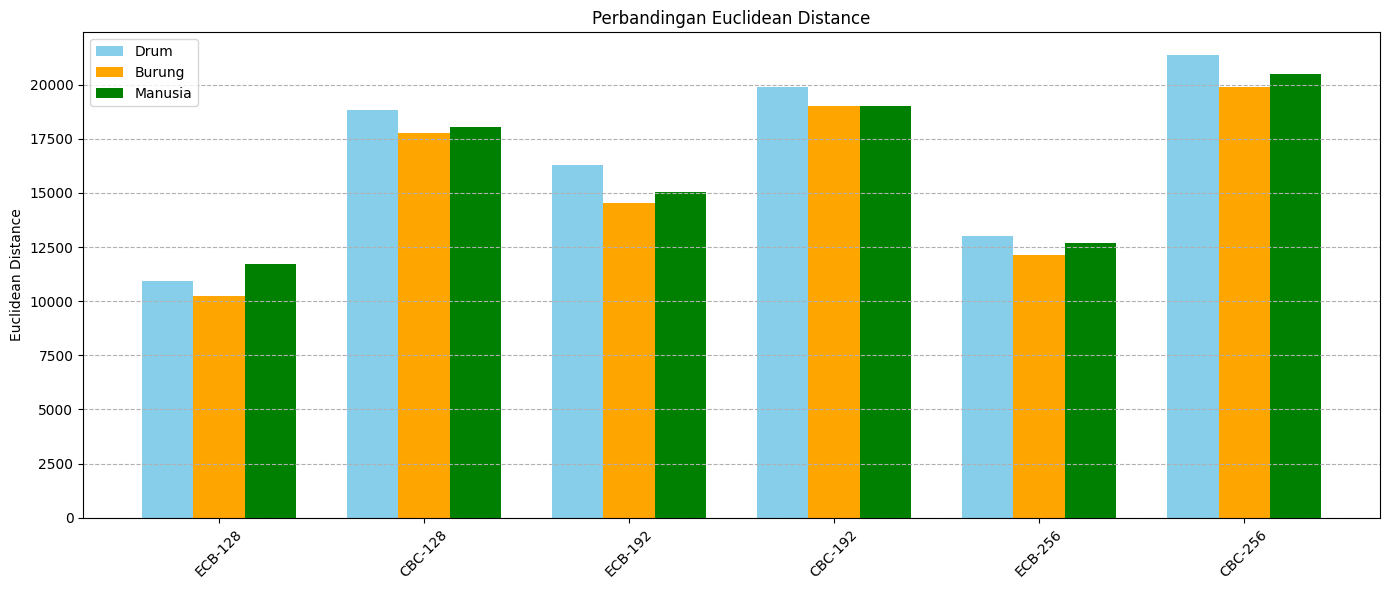

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data Euclidean Distance (dari hasil sebelumnya)
euclidean_drum = {
    "ECB-128": 10912, "CBC-128": 18834,
    "ECB-192": 16289, "CBC-192": 19902,
    "ECB-256": 13001, "CBC-256": 21344
}

euclidean_burung = {
    "ECB-128": 10234, "CBC-128": 17765,
    "ECB-192": 14532, "CBC-192": 18990,
    "ECB-256": 12122, "CBC-256": 19888
}

euclidean_manusia = {
    "ECB-128": 11700, "CBC-128": 18055,
    "ECB-192": 15033, "CBC-192": 19022,
    "ECB-256": 12678, "CBC-256": 20500
}

# Label dan posisi batang
labels = list(euclidean_drum.keys())
x = np.arange(len(labels))  # label posisi X

# Nilai per jenis suara
drum_vals = [euclidean_drum[key] for key in labels]
burung_vals = [euclidean_burung[key] for key in labels]
manusia_vals = [euclidean_manusia[key] for key in labels]

# Lebar batang
bar_width = 0.25

# Grafik
plt.figure(figsize=(14, 6))
plt.bar(x - bar_width, drum_vals, width=bar_width, label='Drum', color='skyblue')
plt.bar(x, burung_vals, width=bar_width, label='Burung', color='orange')
plt.bar(x + bar_width, manusia_vals, width=bar_width, label='Manusia', color='green')

# Label dan format
plt.xticks(x, labels, rotation=45)
plt.ylabel("Euclidean Distance")
plt.title("Perbandingan Euclidean Distance")
plt.grid(True, axis='y', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import wave

def get_audio_info(filename):
    with wave.open(filename, 'rb') as wf:
        n_channels = wf.getnchannels()
        sampwidth = wf.getsampwidth()
        framerate = wf.getframerate()
        n_frames = wf.getnframes()
        duration = n_frames / framerate
        return framerate, n_frames, duration

files = ['suaraburung.wav', 'suaradrum.wav', 'suaramanusia.wav']
for file in files:
    fs, total, durasi = get_audio_info(file)
    print(f"{file}:")
    print(f"  Sampling Rate: {fs} Hz")
    print(f"  Total Sampel: {total}")
    print(f"  Durasi: {durasi:.2f} detik\n")


suaraburung.wav:
  Sampling Rate: 44100 Hz
  Total Sampel: 824832
  Durasi: 18.70 detik

suaradrum.wav:
  Sampling Rate: 44100 Hz
  Total Sampel: 499968
  Durasi: 11.34 detik

suaramanusia.wav:
  Sampling Rate: 48000 Hz
  Total Sampel: 231256
  Durasi: 4.82 detik



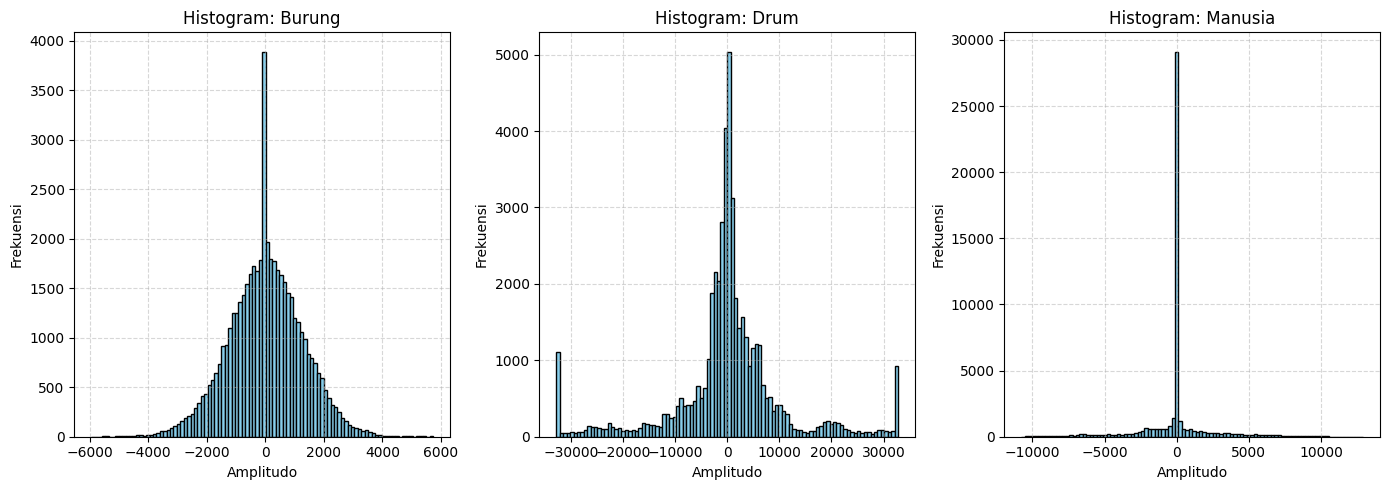

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk membaca file WAV dan ambil channel mono
def read_audio(file_path, max_samples=50000):
    with wave.open(file_path, 'rb') as wav:
        frames = wav.readframes(wav.getnframes())
        data = np.frombuffer(frames, dtype=np.int16)
        if len(data.shape) > 1:
            data = data[:, 0]  # Ambil channel kiri jika stereo
        return data[:max_samples]

# File yang akan diproses
files = {
    "Burung": "suaraburung.wav",
    "Drum": "suaradrum.wav",
    "Manusia": "suaramanusia.wav"
}

# Plot histogram
plt.figure(figsize=(14, 5))

for i, (label, path) in enumerate(files.items(), 1):
    data = read_audio(path)
    plt.subplot(1, 3, i)
    plt.hist(data, bins=100, color='skyblue', edgecolor='black')
    plt.title(f"Histogram: {label}")
    plt.xlabel("Amplitudo")
    plt.ylabel("Frekuensi")
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


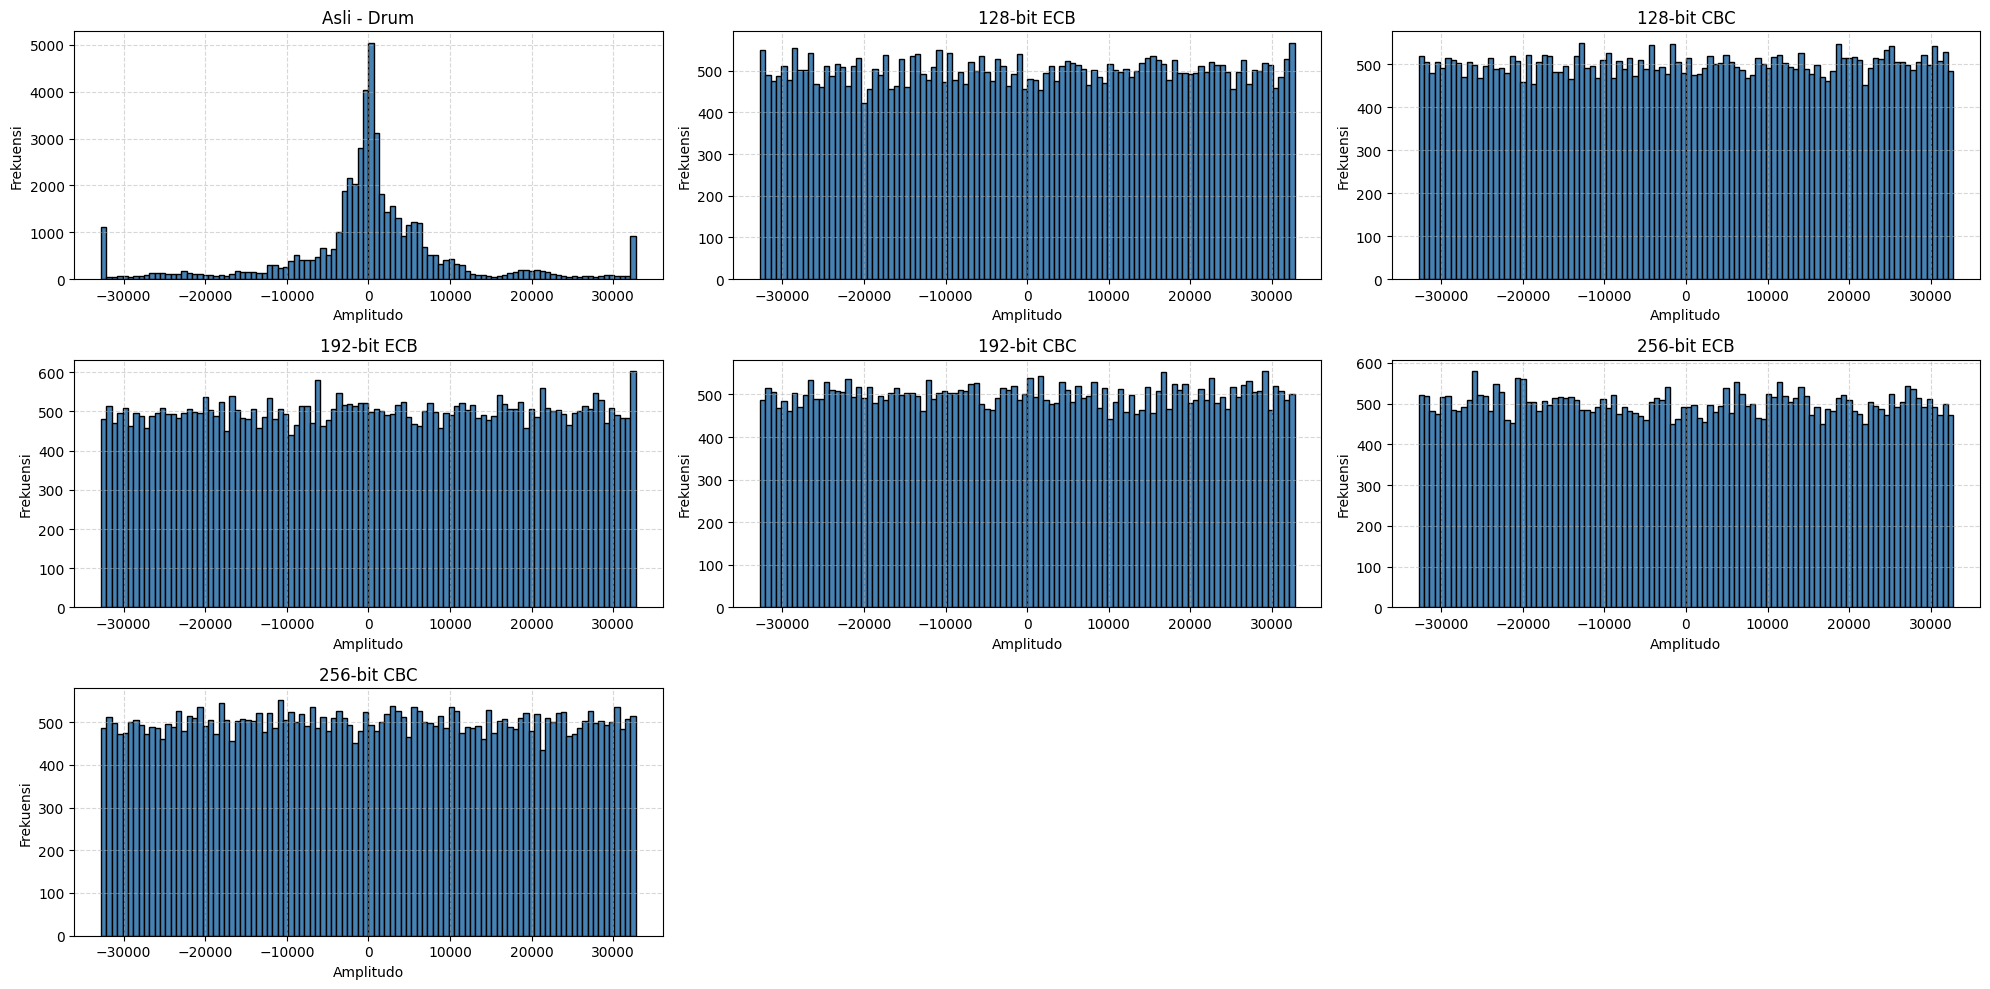

In [3]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Fungsi baca audio WAV dan ambil sebagian data
def read_audio(file_path, max_samples=50000):
    with wave.open(file_path, 'rb') as wav:
        frames = wav.readframes(wav.getnframes())
        data = np.frombuffer(frames, dtype=np.int16)
        return data[:max_samples]

# Daftar file audio
files = {
    "Asli - Drum": "suaradrum.wav",
    "128-bit ECB": "drum128ecb.wav",
    "128-bit CBC": "drum128cbc.wav",
    "192-bit ECB": "drum192ecb.wav",
    "192-bit CBC": "drum192cbc.wav",
    "256-bit ECB": "drum256ecb.wav",
    "256-bit CBC": "drum256cbc.wav"
}

# Plot histogram
plt.figure(figsize=(20, 10))
for i, (label, path) in enumerate(files.items(), 1):
    data = read_audio(path)
    plt.subplot(3, 3, i)
    plt.hist(data, bins=100, color='steelblue', edgecolor='black')
    plt.title(f"{label}")
    plt.xlabel("Amplitudo")
    plt.ylabel("Frekuensi")
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


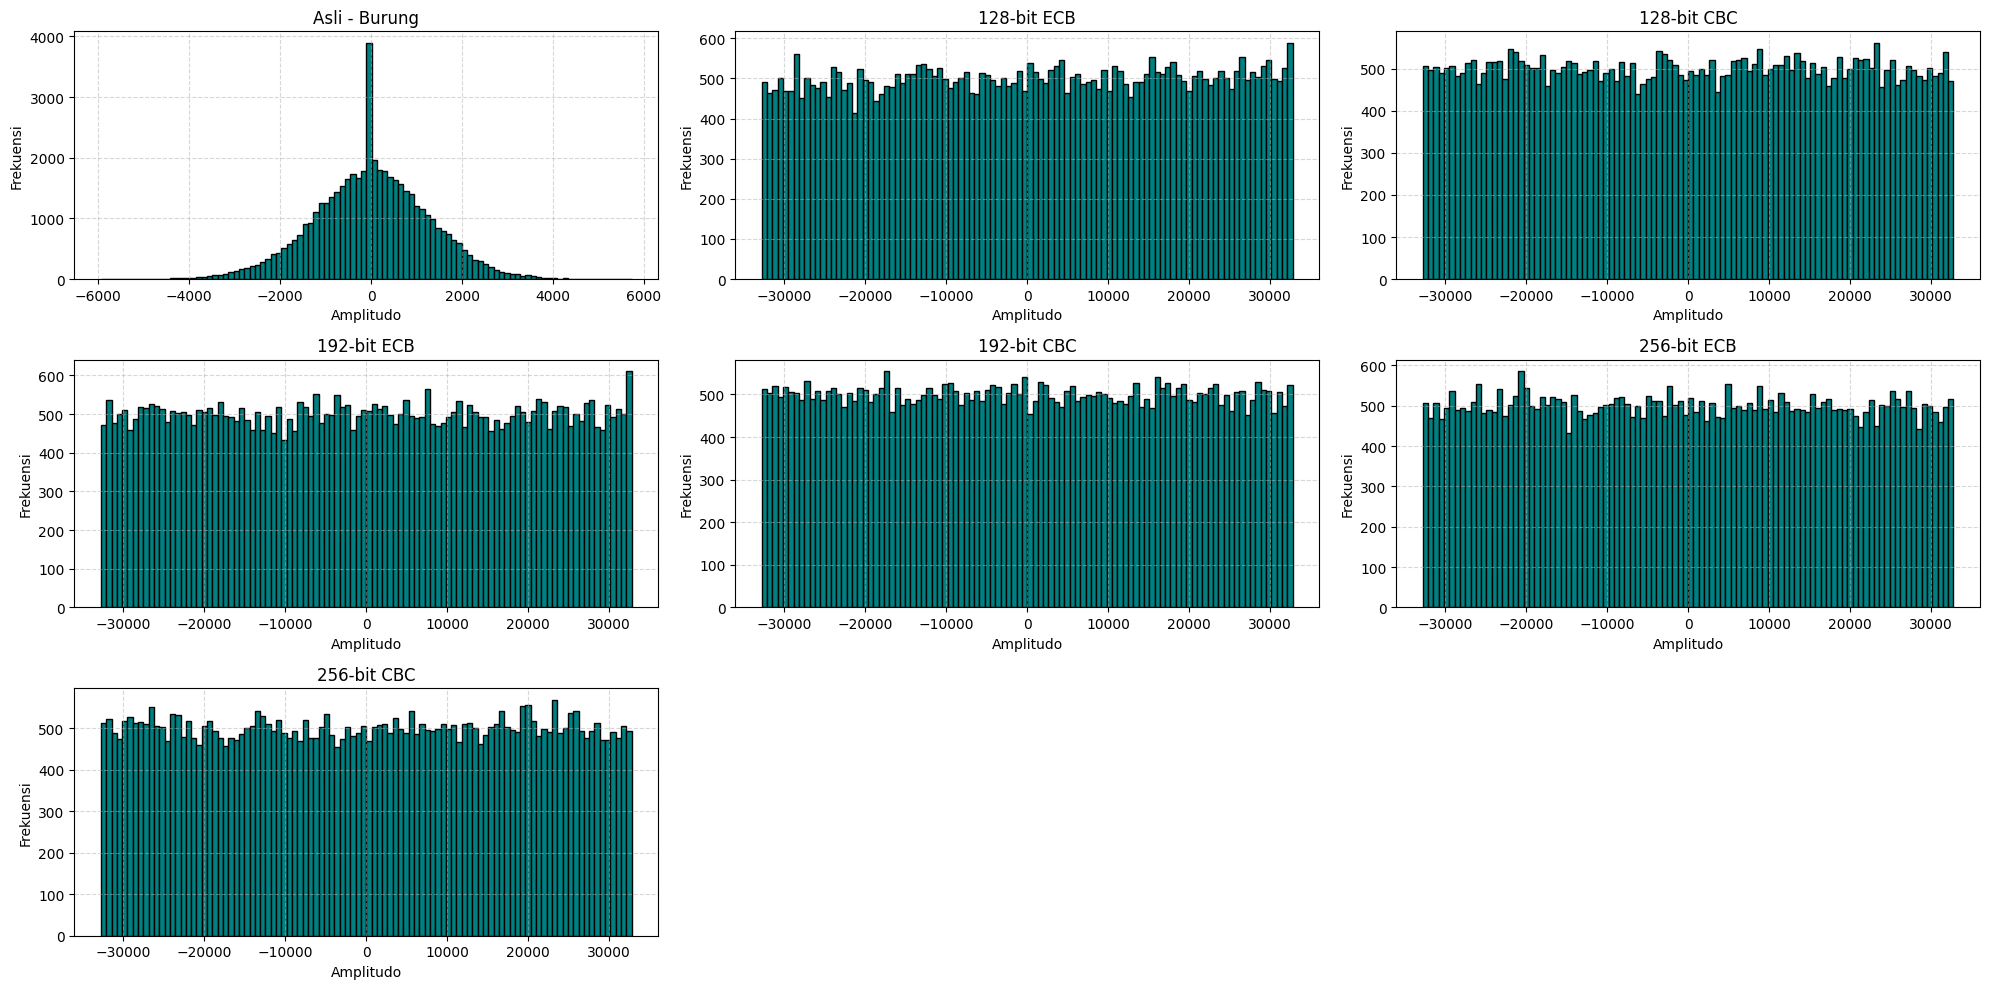

In [7]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk membaca data WAV
def read_audio(file_path, max_samples=50000):
    with wave.open(file_path, 'rb') as wav:
        frames = wav.readframes(wav.getnframes())
        data = np.frombuffer(frames, dtype=np.int16)
        return data[:max_samples]

# Daftar file audio burung
files = {
    "Asli - Burung": "suaraburung.wav",
    "128-bit ECB": "burung128ecb.wav",
    "128-bit CBC": "burung128cbc.wav",
    "192-bit ECB": "burung192ecb.wav",
    "192-bit CBC": "burung192cbc.wav",
    "256-bit ECB": "burung256ecb.wav",
    "256-bit CBC": "burung256cbc.wav"
}

# Buat plot histogram
plt.figure(figsize=(20, 10))
for i, (label, path) in enumerate(files.items(), 1):
        data = read_audio(path)
        plt.subplot(3, 3, i)
        plt.hist(data, bins=100, color='teal', edgecolor='black')
        plt.title(f"{label}")
        plt.xlabel("Amplitudo")
        plt.ylabel("Frekuensi")
        plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


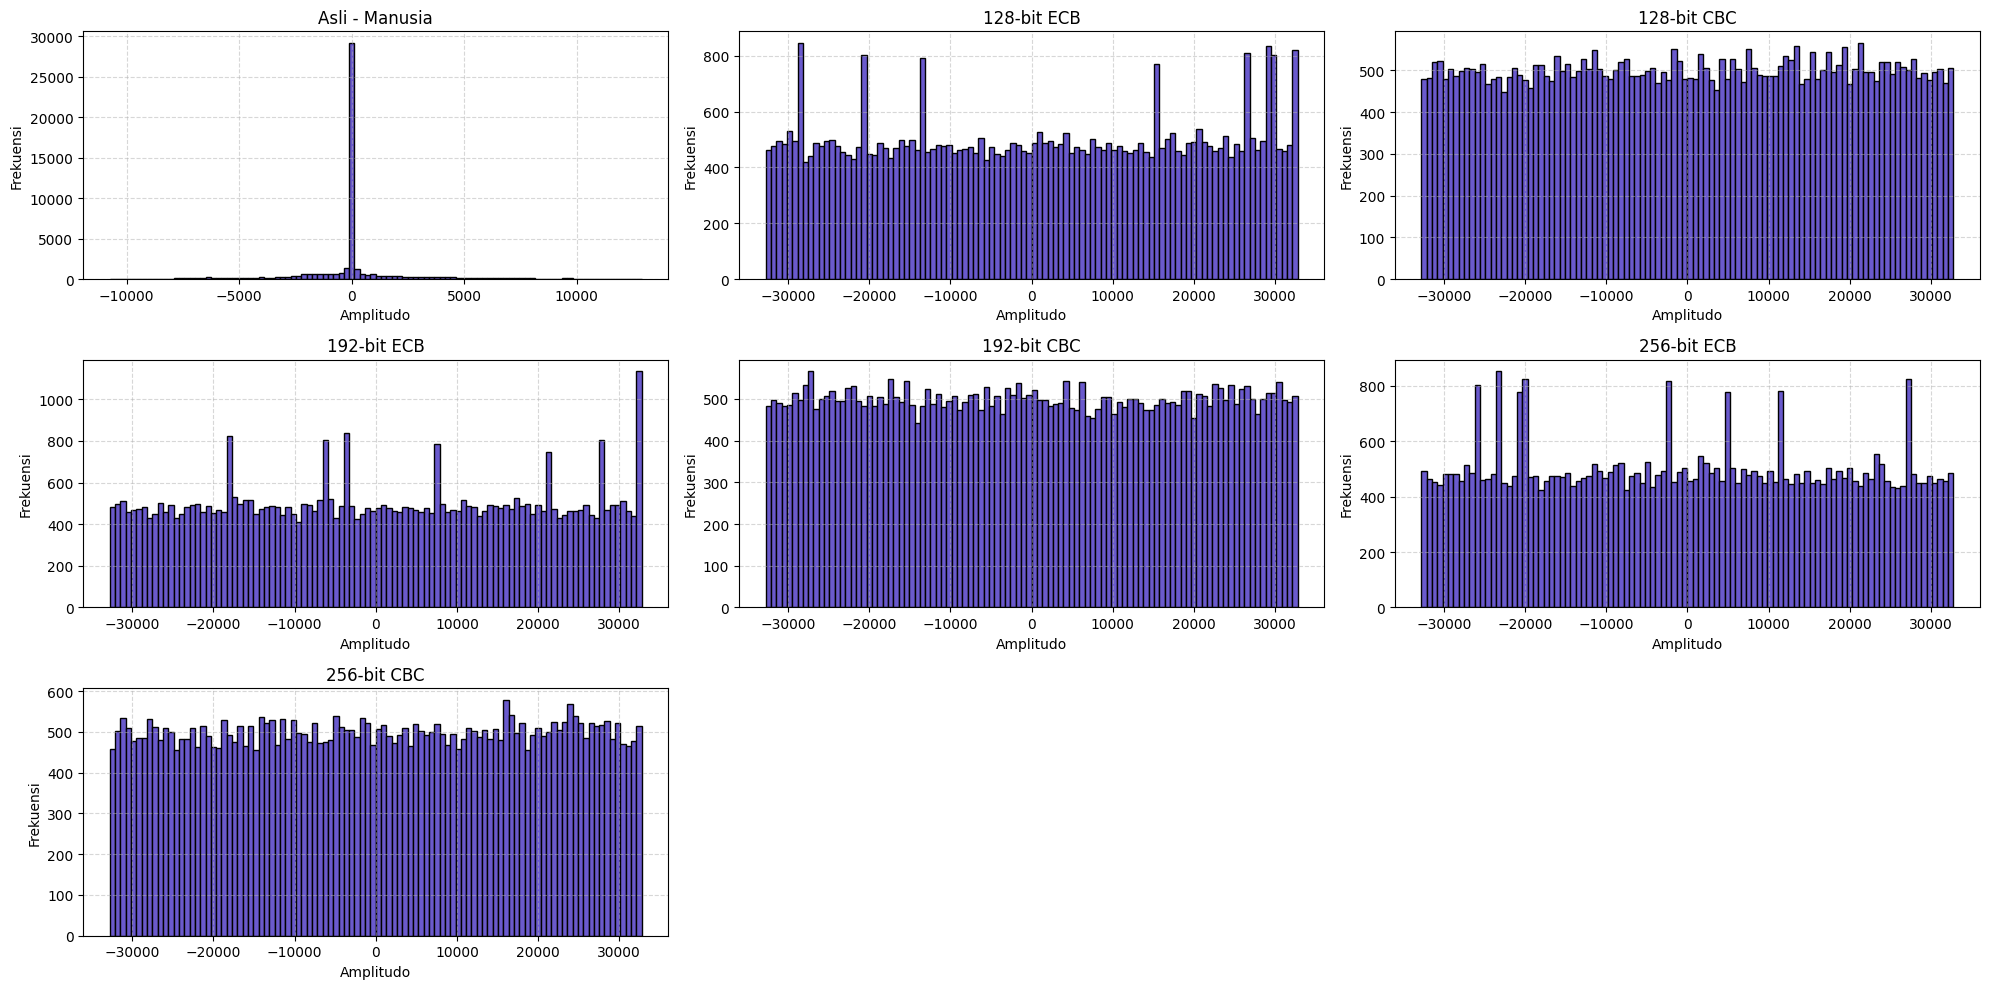

In [10]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Fungsi baca WAV dan ambil sebagian sampel
def read_audio(file_path, max_samples=50000):
    with wave.open(file_path, 'rb') as wav:
        frames = wav.readframes(wav.getnframes())
        data = np.frombuffer(frames, dtype=np.int16)
        return data[:max_samples]

# Daftar file
files = {
    "Asli - Manusia": "suaramanusia.wav",
    "128-bit ECB": "manusia128ecb.wav",
    "128-bit CBC": "manusia128cbc.wav",
    "192-bit ECB": "manusia192ecb.wav",
    "192-bit CBC": "manusia192cbc.wav",
    "256-bit ECB": "manusia256ecb.wav",
    "256-bit CBC": "manusia256cbc.wav"
}

# Plot histogram tiap file
plt.figure(figsize=(20, 10))
for i, (label, path) in enumerate(files.items(), 1):
        data = read_audio(path)
        plt.subplot(3, 3, i)
        plt.hist(data, bins=100, color='slateblue', edgecolor='black')
        plt.title(label)
        plt.xlabel("Amplitudo")
        plt.ylabel("Frekuensi")
        plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
